In [20]:
#%% Imports
%matplotlib inline
import os
import pymysql
import pyneb as pn
import numpy as np
import matplotlib.pyplot as plt
from pyneb.utils.physics import IP
import joblib
import ai4neb
import pandas as pd
import seaborn as sns
import re
pn.config.use_multiprocs()

In [2]:
#pn.atomicData.setDataFile('ar_iv_coll_ZBL87.dat')
pn.log_.level=1

In [21]:
def print_obs():
    H1 = pn.RecAtom('H', 1)
    tem = 1e4
    den = 1e2
    Hab = H1.getEmissivity(tem, den, label='3_2') / H1.getEmissivity(tem, den, label='4_2')
    Hgb = H1.getEmissivity(tem, den, label='5_2') / H1.getEmissivity(tem, den, label='4_2')
    Hdb = H1.getEmissivity(tem, den, label='6_2') / H1.getEmissivity(tem, den, label='4_2')
    
    tab1 = pd.read_csv('tab1.tex', delimiter='&', usecols=(0,1), names=('ID', 'lam2'))
    tab2 = pd.read_csv('PC22_R2R4_final.dat', delim_whitespace=True)
    
    tab2.rename(columns={'R2R4flux':'Fl'}, inplace=True)
    tab = pd.concat([tab1, tab2], axis=1)
    tab.set_index('LINE', inplace=True)
    
    tab3 = pd.read_csv('PC22_LS20_new.dat', delim_whitespace=True, usecols=(0,1, 2, 3, 4, 5, 6, 7, 8))
    tab3.set_index('LINE', inplace=True)
    tabm = pd.concat([tab, tab3], axis=1)
    tab = None
    
    RCT = pn.RedCorr(law='CCM89')
    RC1 = pn.RedCorr(law='CCM89')
    RC2 = pn.RedCorr(law='CCM89')
    RC4 = pn.RedCorr(law='CCM89')
    RC5 = pn.RedCorr(law='CCM89')
    Ha = tabm.loc['H1r_6563A']
    Hb = tabm.loc['H1r_4861A']
    Hg = tabm.loc['H1r_4341A']
    Hd = tabm.loc['H1r_4102A']
    
    for RC, flstr in zip((RCT, RC1, RC2, RC4, RC5), ('Fl', 'R1flux', 'R2flux', 'R4flux', 'R5flux')):
        RC.setCorr( Ha[flstr] / Hb[flstr] / Hab, Ha['lam'], Hb['lam'])
        c_ab = RC.cHbeta
        if Hg[flstr] > 1e-20:
            RC.setCorr( Hg[flstr] / Hb[flstr] / Hgb, Hg['lam'], Hb['lam'])
            c_gb = RC.cHbeta
            RC.setCorr( Hd[flstr] / Hb[flstr] / Hdb, Hd['lam'], Hb['lam'])
            c_db = RC.cHbeta
            print('C(Hbeta) Ha/Hb: {:.2f}, Hg/Hb: {:.2f}, Hd/Hb: {:.2f}'.format(c_ab, c_gb, c_db))
            RC.cHbeta = np.nanmean((c_ab, c_gb, c_db))
        else:
            print('C(Hbeta) Ha/Hb: {:.2f}'.format(c_ab))
            RC.cHbeta = c_ab       
    
    syst_error = 0.1
    tabm['Fnorm'] = tabm['Fl'] / Hb['Fl'] * 100
    errquad = np.sqrt(tabm['err']**2 + (syst_error * tabm['Fl'])**2)
    tabm['enorm'] =  errquad / Hb['Fl'] * 100 
    tabm['Icorr'] = tabm['Fl'] * RCT.getCorr(tabm.lam)
    tabm['IcorrHb'] = tabm['Icorr'] / tabm.loc['H1r_4861A', 'Icorr'] * 100
    tabm['ecorrHb'] = errquad * RCT.getCorr(tabm.lam) / tabm.loc['H1r_4861A', 'Icorr'] * 100
    tabm.loc['H1r_4861A','enorm'] = 0
    tabm.loc['H1r_4861A','ecorrHb'] = 0    
    
    f1 = open('./PC22_R2R4_clean_final3.dat', 'w')
    f1.write('LINE         R2R4flux err\n')
    for i, l in tabm.iterrows():
        to_print = '{:10s} {:10.4f} {:6.4f}'.format(i, l['Fnorm'], l['enorm'])
        print(to_print)
        f1.write('{}\n'.format(to_print))
#    f1.write('cHbeta         {}   0.0\n'.format(RC.cHbeta))
    f1.close()
        
    f2 = open('./tab2_final3.tex', 'w')
    for i, l in tabm.iterrows():
        to_print='{:35s} & {:4.0f} & {:8.2f} $\pm${:6.2f} \\\\'.format(l['ID'], l['lam'], l['IcorrHb'], l['ecorrHb'])
        print(to_print)
        f2.write('{}\n'.format(to_print))
    f2.write('\hline \n')
    f2.write('c(H$\\beta$) & & {:.2f} \\\\\n'.format(RCT.cHbeta))
    f2.write('\hline \n')
    f2.close()

    syst_error = 0.1
    for RC, i_str in zip((RC1, RC2, RC4, RC5),('1', '2', '4', '5')):
        tabm['Fnorm{}'.format(i_str)] = tabm['R{}flux'.format(i_str)] / Hb['R{}flux'.format(i_str)] * 100
        errquad = np.sqrt(tabm['err'.format(i_str)]**2 + (syst_error * tabm['R{}flux'.format(i_str)])**2)
        tabm['enorm{}'.format(i_str)] =  errquad / Hb['R{}flux'.format(i_str)] * 100 
        tabm['Icorr{}'.format(i_str)] = tabm['R{}flux'.format(i_str)] * RC.getCorr(tabm.lam)
        tabm['IcorrHb{}'.format(i_str)] = tabm['Icorr{}'.format(i_str)] / tabm.loc['H1r_4861A', 'Icorr{}'.format(i_str)] * 100
        tabm['ecorrHb{}'.format(i_str)] = errquad * RC.getCorr(tabm.lam) / tabm.loc['H1r_4861A', 'Icorr{}'.format(i_str)] * 100
        mask = tabm['Fnorm{}'.format(i_str)] == 0
        tabm['enorm{}'.format(i_str)].iloc[mask] = 0.0
        tabm['ecorrHb{}'.format(i_str)].iloc[mask] = 0.0
    f = open('./tab1_final3.tex', 'w')
    for i, l in tabm.iterrows():
        to_print = """{0[ID]:40s} & {0[lam2]:4.0f} & 
        {0[Fnorm1]:7.1f} $\pm${0[enorm1]:5.1f} & {0[IcorrHb1]:7.1f} $\pm${0[ecorrHb1]:5.1f} & 
        {0[Fnorm2]:7.1f} $\pm${0[enorm2]:5.1f} & {0[IcorrHb2]:7.1f} $\pm${0[ecorrHb2]:5.1f} & 
        {0[Fnorm4]:7.1f} $\pm${0[enorm4]:5.1f} & {0[IcorrHb4]:7.1f} $\pm${0[ecorrHb4]:5.1f} & 
        {0[Fnorm5]:7.1f} $\pm${0[enorm5]:5.1f} & {0[IcorrHb5]:7.1f} $\pm${0[ecorrHb5]:5.1f} 
        \\\\""".format(l)
        to_print = re.sub('0.0 \$\\\pm\$  0.0','      -       ', to_print)
        print(to_print)
        f.write('{}\n'.format(to_print))
    f.write('\hline \n')
    f.write('c(H$\\beta$) & & & {:.2f} & & {:.2f} & & {:.2f} & & {:.2f} \\\\\n'.format(RC1.cHbeta, RC2.cHbeta, RC4.cHbeta, RC5.cHbeta))
    f.write('\hline \n')
    f.write('H$\\beta$/1e15 erg/s/cm2 &&{:.3f}  & {:.3f} & {:.3f} & {:.3f} &{:.3f}  & {:.3f} &{:.3f}  & {:.3f} \\\\\n'.format(tabm.loc['H1r_4861A']['R1flux']*1e15,
                                                                                                 tabm.loc['H1r_4861A']['Icorr1']*1e15,
                                                                                  tabm.loc['H1r_4861A']['R2flux']*1e15,               
                                                                                  tabm.loc['H1r_4861A']['Icorr2']*1e15,
                                                                                  tabm.loc['H1r_4861A']['R4flux']*1e15,               
                                                                                  tabm.loc['H1r_4861A']['Icorr4']*1e15,
                                                                                  tabm.loc['H1r_4861A']['R5flux']*1e15,               
                                                                                  tabm.loc['H1r_4861A']['Icorr5']*1e15
                                                                                  ))
    f.write('log H$\\beta$ erg/s/cm2 &&{:.2f}& {:.2f} & {:.2f}& {:.2f} &{:.2f} & {:.2f} &{:.2f} & {:.2f} \\\\\n'.format(np.log10(tabm.loc['H1r_4861A']['R1flux']),
                                                                                                np.log10(tabm.loc['H1r_4861A']['Icorr1']),
                                                                                  np.log10(tabm.loc['H1r_4861A']['R2flux']),
                                                                                  np.log10(tabm.loc['H1r_4861A']['Icorr2']),
                                                                                  np.log10(tabm.loc['H1r_4861A']['R4flux']),
                                                                                  np.log10(tabm.loc['H1r_4861A']['Icorr4']),
                                                                                  np.log10(tabm.loc['H1r_4861A']['R5flux']),
                                                                                  np.log10(tabm.loc['H1r_4861A']['Icorr5'])))
    

    f.close()
    return tabm
#%%
tabm = print_obs()

C(Hbeta) Ha/Hb: 0.43, Hg/Hb: 0.19, Hd/Hb: 0.23
C(Hbeta) Ha/Hb: 0.61
C(Hbeta) Ha/Hb: 0.29, Hg/Hb: 0.29, Hd/Hb: 0.37
C(Hbeta) Ha/Hb: 0.57, Hg/Hb: 0.17, Hd/Hb: 0.22
C(Hbeta) Ha/Hb: 0.10
Ne5_3346A     33.8462 4.1812
Ne5_3426A     89.2799 9.3275
O2_3727A+     20.8674 3.2220
H1r_3798A      4.5802 3.6297
H1r_3835A      7.8699 0.9364
Ne3_3869A     66.2848 6.6511
H1r_3889A     10.6465 1.0945
H1r_3970A     31.0802 3.1960
S2_4069A       1.7504 0.6619
H1r_4102A     22.9624 2.3353
He2r_4198A     1.6596 0.5338
H1r_4341A     43.7234 4.3797
O3_4363A      13.1997 1.3397
He1r_4471A     0.8650 0.2071
He2r_4542A     3.4165 0.5084
N3r_4634A      0.5818 0.2048
O2r_4640A      1.2234 0.2890
He2r_4686A   123.8134 12.3848
Ar4_4711A     18.4370 1.8550
Ne4_4726A      2.1375 0.2643
Ar4_4740A     14.0589 1.4164
H1r_4861A    100.0000 0.0000
O3_4959A     358.1833 35.8184
O3_5007A    1076.1047 107.6107
He2r_5411A    10.4501 1.0475
Cl3_5518A      1.6416 0.1761
Cl3_5538A      1.2676 0.1943
N2_5755A       0.8666 0.1503
H

/Users/christophemorisset/anaconda3/envs/ML2/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/christophemorisset/anaconda3/envs/ML2/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/christophemorisset/anaconda3/envs/ML2/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

In [3]:
obs_filename = 'PC22_R2R4.dat'

In [4]:
def make_ANN_diags():
    
    obs = pn.Observation()
    obs.readData(obs_filename, fileFormat='lines_in_rows_err_cols', corrected=False, errIsRelative = False)
    obs.extinction.law = 'CCM89'
    obs.extinction.R_V = 3.1
    obs.def_EBV()
    obs.correctData(normWave = 4861)
    
    diag_n2 = '[NII] 5755/6584+'
    diag_o3 = '[OIII] 4363/5007+'
    diag_s2 = '[SII] 6731/6716'
    diag_cl3 = '[ClIII] 5538/5518' 
    diag_ar4 = '[ArIV] 4740/4711'
    
    diags = pn.Diagnostics()
    diags.addDiagsFromObs(obs)
    
    # Set up some parameters of the Regresor Method object
    diags.ANN_inst_kwargs['random_seed'] = 43
    diags.ANN_inst_kwargs['verbose'] = True
    
    # Set up some parameters of the Analogic Neural Network
    diags.ANN_init_kwargs['hidden_layer_sizes'] = (10, 30, 10)
    diags.ANN_init_kwargs['activation'] = 'tanh' 
    diags.ANN_n_tem = 30
    diags.ANN_n_den = 30                
    
    t_n2, d_S2 = diags.getCrossTemDen(diag_n2, diag_s2, obs=obs,
                                      use_ANN=True, 
                                      start_den=1e1, end_den=1e6, 
                                      start_tem=3e3, end_tem=1.8e4,
                                      limit_res=True)
    diags.ANN.save_RM('ANN_tn2_ds2')
    
    t_O3, d_Cl3 = diags.getCrossTemDen(diag_o3, diag_cl3, obs=obs,
                                      use_ANN=True, 
                                      start_den=1e1, end_den=1e6, 
                                      start_tem=3e3, end_tem=1.8e4,
                                      limit_res=True)
    diags.ANN.save_RM('ANN_to3_dcl3')
    t_O3, d_Ar4 = diags.getCrossTemDen(diag_o3, diag_ar4, obs=obs,
                                      use_ANN=True, 
                                      start_den=1e1, end_den=1e6, 
                                      start_tem=3e3, end_tem=1.8e4,
                                      limit_res=True)
    diags.ANN.save_RM('ANN_to3_dar4')

In [5]:
def get_models():

    co = pymysql.connect(host=os.environ['MdB_HOST'],
                         user=os.environ['MdB_USER'],
                         passwd=os.environ['MdB_PASSWD'],
                         db=os.environ['MdB_DB_17'])
    res = pd.read_sql("""select
    tab_17.ref, tab_17.N, com1, com6, log10(atm1) as Teff, massfrac, oxygen, dens, logU_mean,
    NE_5_342603A + NE_5_334599A as ne5, 0.62*BLND_472000A as ne4, NE_3_386876A as ne3, 
    AR_5_643512A as ar5, AR_4_474012A + AR_4_471126A as ar4,
    O__3_500684A as o3, BLND_372700A  as o2, BLND_436300A as o3_63,
    HE_1_587564A as he1, HE_2_468564A as he2, H__1_486133A as hb, 
    CA_B_486133A as hb_b, CA_B_587564A as he1_b, CA_B_468564A as he2_b,
    S__2_671644A + S__2_673082A as s2, S__3_631206A as s3,
    A_NITROGEN_vol_1 as an1,
    A_OXYGEN_vol_1 as ao1, A_OXYGEN_vol_2 as ao2,
    A_NEON_vol_2 as ane2, A_NEON_vol_3 as ane3, A_NEON_vol_4 as ane4,
    A_ARGON_vol_3 as aar3,A_ARGON_vol_4 as aar4,
    A_SULPHUR_vol_1 as as1, A_SULPHUR_vol_2 as as2,
    A_CHLORINE_vol_2 as acl2, THp as T0
    FROM tab_17, abion_17 
    WHERE tab_17.N=abion_17.N AND tab_17.ref = 'PNe_2020' """,
                      con=co)

    co.close()
    joblib.dump(res, 'PN2020_3MdB.sav')

In [6]:
class ABUND(object):
    def __init__(self, obs_data = obs_filename, ext_law = 'CCM89', 
                 N_montecarlo = None, i_obs = None, figsize = (10,5), use_ANN=False,
                 corr_err=1.0, RM_type='ANN', N_out=11, N_in=5,
                 fact_RC_mean=1):
        
        self.i_obs = i_obs
        self.use_ANN = use_ANN
        self.RM_type = RM_type
        self.N_in = N_in
        self.N_out = N_out
        self.figsize = figsize
        self.RM_filename = 'ICF_trained/ICFs_{}-{}-PC22_{}_CM'.format(N_in, N_out, self.RM_type)
        self.fig_dir = './figs_{}_{}/'.format(self.RM_type, N_out)
        self.corr_err = corr_err
        self.some_init()
        self.obs = self.get_obs(obs_data, N_montecarlo, ext_law, fact_RC_mean=fact_RC_mean)
        self.icf = pn.ICF()
        
    def some_init(self):
        
        self.icf_ref = {'ICF_HeH':'ICF(He$^+$ + He$^{++}$)=1',
                       'ICF_OH': 'ICF(O$^+$ + O$^{++}$)',
                       'ICF_NO': 'ICF(N$^+$/O$^+$)',
                       'ICF_NeO': 'ICF(Ne$^{++}$/O$^{++}$)',
                       'ICF_NeH234': 'ICF(Ne$^{+2}$ + Ne$^{+3}$ + Ne$^{+4}$)',
                       'ICF_NeH24': 'ICF(Ne$^{+2}$ + Ne$^{+4}$)',
                       'ICF_SH': 'ICF(S$^+$ + S$^{++}$)',
                       'ICF_SO': 'ICF((S$^+$ + S$^{++}$)/O$^{++}$)',
                       'ICF_SO1': 'ICF((S$^+$ + S$^{++}$)/O$^{+}$)',
                       'ICF_ClO': 'ICF(Cl$^{++}$/O$^{++}$)',
                       'ICF_ClO1': 'ICF(Cl$^{++}$/O$^{+}$)',
                       'ICF_ArH': 'ICF(Ar$^{+3}$+ Ar$^{+4}$)'
                       }
        
        self.icf_short = {'ICF_HeH':'0',
                           'ICF_OH': '1',
                           'ICF_NO': '2',
                           'ICF_NeO': '3',
                           'ICF_NeH': '4',
                           'ICF_NeH24': '4',
                           'ICF_NeH234': '4',
                           'ICF_SH': '5',
                           'ICF_SO': '6',
                           'ICF_SO1': '7',
                           'ICF_ClO': '8',
                           'ICF_ClO1': '9',
                           'ICF_ArH': '10'
                       }
        self.icf_labels = ['ICF(O$^+$ + O$^{{++}}$)',
                           'ICF(N$^+$/O$^+$)',
                           'ICF(Ne$^{{+2}}$ + Ne$^{{+4}}$)',
                           'ICF(Ne$^{{+2}}$ + Ne$^{{+3}}$ + Ne$^{{+4}}$)',
                           'ICF(Ne$^{{++}}$/O$^{{++}}$)',
                           'ICF((S$^+$ + S$^{{++}}$)/O$^{++}$)',
                           'ICF(Cl$^{{++}}$/O$^{{++}}$)',
                           'ICF(S$^+$ + S$^{{++}}$)',
                           'ICF(Ar$^{{+3}}$+ Ar$^{{+4}}$)']
        
        if self.N_out == 11:
            self.icf_labels.append('ICF((S$^+$ + S$^{++}$)/O$^+$)')
            self.icf_labels.append('ICF(Cl$^{++}$/O$^{+}$)')

        self.spec_ions = {'Ar4':'Ar$^{+3}$', 'Ar5':'Ar$^{+4}$', 'Cl3':'Cl$^{++}$', 'H1r':'H$^+$', 
                          'He1r': 'He$^+$', 'He2r': 'He$^{++}$', 'K4': 'K$^{+3}$', 'N2': 'N$^+$', 
                          'Ne3':'Ne$^{++}$', 'Ne4':'Ne$^{+3}$', 'Ne5':'Ne$^{+4}$', 'O1':'O$^0$', 
                          'O2':'O$^+$', 'O3':'O$^{++}$', 'S2':'S$^{+}$', 'S3':'S$^{++}$'}
        
        self.lab_diag = {'[OIII] 4363/5007+[ClIII] 5538/5518':'o3_cl3', '[OIII] 4363/5007+[ArIV] 4740/4711':'o3_ar4',
                         '[NII] 5755/6584+[SII] 6731/6716':'n2_s2'}
        
        self.icf_list = ['KB94_A10', 'KB94_A27', 'KB94_A28.10', 'KB94_A36.10', 
                         'KB94_A1.10', 'DIMS14_12', 'DIMS14_14', 'DIMS14_17a', 
                         'DIMS14_20', 'DIMS14_26', 'DIMS14_29']
        
        self.ion_spec = {'He1r': r'He$^+$',
                        'He2r': r'He$^{++}$',
                        'N2': r'N$^+$',
                        'O1': r'O$^0$',
                        'O2': r'O$^+$',
                        'O3': r'O$^{++}$',
                        'S2': r'S$^{+}$',
                        'S3': r'S$^{++}$',
                        'Cl3': r'Cl$^{++}$',
                        'Ar4': r'Ar$^{3+}$',
                        'Ar5': r'Ar$^{4+}$',
                        'Ne3': r'Ne$^{++}$',
                        'Ne4': r'Ne$^{3+}$',
                        'Ne5': r'Ne$^{4+}$'
                    }
                
    def get_obs(self, obs_data, N_montecarlo, ext_law, fact_RC_mean=1):
        
        obs = pn.Observation()
        obs.readData(obs_data, fileFormat='lines_in_rows_err_cols', corrected=False, errIsRelative = False)
        for line in obs.lines:
            line.obsError *= self.corr_err
        if N_montecarlo is not None:
            np.random.seed(1)
            obs.addMonteCarloObs(N = N_montecarlo, i_obs = self.i_obs)
        obs.extinction.law = ext_law
        obs.extinction.R_V = 3.1 #+ 0.2 * (1-2*np.random.rand(N_montecarlo+1))
        obs.def_EBV(label1="H1r_6563A", label2="H1r_4861A", r_theo=2.86)
        cHb_ab = obs.extinction.cHbeta
        obs.def_EBV(label1="H1r_4341A", label2="H1r_4861A", r_theo=0.468)
        cHb_gb = obs.extinction.cHbeta
        obs.def_EBV(label1="H1r_4102A", label2="H1r_4861A", r_theo=0.259)
        cHb_db = obs.extinction.cHbeta
        fact = np.random.rand(N_montecarlo+1)
        fact[0] = 1
        if fact_RC_mean == 1:
            fact = 1
        elif fact_RC_mean == 0:
            fact = 0
        obs.extinction.cHbeta = (fact * np.mean((cHb_ab, cHb_gb, cHb_db), axis=0) +
                                 (1-fact) * cHb_ab)
        #obs.extinction.cHbeta = np.mean((cHb_ab, cHb_ab, cHb_ab, cHb_gb, cHb_db), axis=0)
        #obs.extinction.cHbeta = cHb_ab
        obs.correctData(normWave = 4861)
        return obs
        
    def __temden(self, tem_diag, den_diag, ANN_file=None):
        if ( tem_diag in self.diags.diags.keys() ) & ( den_diag in self.diags.diags.keys()):
            if self.use_ANN:
                print('getCrossTemDen using ANN')
                
                # Set up some parameters of the Regresor Method object
                self.diags.ANN_inst_kwargs['random_seed'] = 43
                #diags.ANN_inst_kwargs['use_log'] = False
                self.diags.ANN_inst_kwargs['verbose'] = True
                
                # Set up some parameters of the Analogic Neural Network
                self.diags.ANN_init_kwargs['hidden_layer_sizes'] = (10, 30, 10)
                self.diags.ANN_init_kwargs['activation'] = 'tanh' 
                self.diags.ANN_n_tem = 30
                self.diags.ANN_n_den = 30                
                pn.log_.level=4
                if ANN_file is None:                
                    t, d = self.diags.getCrossTemDen(tem_diag, den_diag, obs=self.obs, i_obs = self.i_obs,
                                                     use_ANN=True, 
                                                     start_den=1e1, end_den=1e6, 
                                                     start_tem=3e3, end_tem=1.8e4,
                                                     limit_res=True)
                else:
                    t, d = self.diags.getCrossTemDen(tem_diag, den_diag, obs=self.obs, i_obs = self.i_obs,
                                                     use_ANN=True, ANN=ANN_file,
                                                     start_den=1e1, end_den=1e6, 
                                                     start_tem=3e3, end_tem=1.8e4,
                                                     limit_res=True)                    
                pn.log_.level=1
            else:
                t, d = self.diags.getCrossTemDen(tem_diag, den_diag, obs=self.obs, i_obs = self.i_obs)
            self.diags_dict['tem'][self.lab_diag[tem_diag+den_diag]] = t
            self.diags_dict['den'][self.lab_diag[tem_diag+den_diag]] = d
        else:
            print('{} and {} diagnostics not found'.format(tem_diag, den_diag))
                    
    def diagnostics(self, plot_diags = False, ax = None):
        self.diags = pn.Diagnostics()
        diag_n2 = '[NII] 5755/6584+'
        diag_o3 = '[OIII] 4363/5007+'
        diag_s2 = '[SII] 6731/6716'
        diag_cl3 = '[ClIII] 5538/5518' 
        diag_ar4 = '[ArIV] 4740/4711'
        for label in (diag_n2, diag_o3, diag_s2, diag_cl3, diag_ar4):
            self.diags.addDiag(label=label)
        self.atoms = pn.getAtomDict(atom_list = self.obs.getUniqueAtoms())
        self.diags.setAtoms(self.atoms)
        self.diags_dict = {}
        self.diags_dict['tem'] = {}
        self.diags_dict['den'] = {}
        if not os.path.isfile('./ANN_tn2_ds2'):
            print('Doing ANN for the getCrossTemDen (only once)')
            make_ANN_diags()
        self.__temden(diag_n2, diag_s2, ANN_file='./ANN_tn2_ds2')
        self.__temden(diag_o3, diag_cl3, ANN_file='./ANN_to3_dcl3')
        self.__temden(diag_o3, diag_ar4, ANN_file='./ANN_to3_dar4')
        self.temp_low = self.diags_dict['tem']['n2_s2']
        self.dens_low = self.diags_dict['den']['n2_s2']
        self.temp_high = np.nanmean( np.array( (self.diags_dict['tem']['o3_cl3'],
                                                     self.diags_dict['tem']['o3_ar4']) ), axis = 0)
        self.dens_high = np.nanmean( np.array( (self.diags_dict['den']['o3_cl3'],
                                                     self.diags_dict['den']['o3_ar4']) ), axis = 0)
        #self.temp_high = np.where(self.temp_high < 15000, self.temp_high, np.nan)
        if plot_diags:
            emisgrids = pn.getEmisGridDict(atomDict = self.diags.atomDict, den_max=1e6)
            self.diags.plot(emisgrids, self.obs, i_obs = 0, ax = ax)
        
    def get_ion_ab(self):
        self.ab_labels = self.obs.lineLabels
        self.ion_ab_dic = {}
        for line in self.obs.getSortedLines():
            if line.label in self.ab_labels and line.is_valid:
                if line.atom in self.atoms:
                    IP_cut = 30. 
                    if IP[line.atom] < IP_cut:
                        temp = self.temp_low
                        dens = self.dens_low
                    else:
                        temp = self.temp_high
                        dens = self.dens_high
#                        dens = self.dens_low
                    ab = self.atoms[line.atom].getIonAbundance(line.corrIntens, 
                                   temp, dens, to_eval=line.to_eval, Hbeta=100.)
                self.ion_ab_dic[line.label] = ab
    
    def get_mean_ion_ab(self):
        self.ionic_mean = {}
        keys_dict = self.ion_ab_dic.keys()
        keys = np.array(list(keys_dict))
        ions = np.array([key.split('_')[0] for key in keys])
        self.unique_ions = np.unique(ions)
        for ion in self.unique_ions:
            mask = ions == ion
            labels_ion = keys[mask]
            self.ionic_mean[ion] = np.ones( (len(labels_ion), len(self.ion_ab_dic[labels_ion[0]]) ) )
            for i, label in enumerate(labels_ion):
                self.ionic_mean[ion][i] = self.ion_ab_dic[label]
            x = np.nanmean(self.ionic_mean[ion], axis = 0)
            self.ionic_mean[ion] = np.where(x <= 0, np.nan, x)
        self.ionic_mean.pop('H1r')
        
    def plot_tene_high(self, legend_size=10, use_log=True):
        fig, (ax1, ax2) = plt.subplots(1,2, figsize = self.figsize)
        ax1.hist(self.diags_dict['tem']['o3_cl3'], bins = 100, alpha = 0.5, label = 'Te([O III])  Ne([Cl III])', color='C0')
        ax1.hist(self.diags_dict['tem']['o3_ar4'], bins = 100, alpha = 0.5, label = 'Te([O III]) Ne([Ar IV])', color='C1')
        #ax1.hist(self.temp_high, bins = 100, alpha = 0.5, label = 'mean')
        ax1.axvline(np.nanmedian(self.diags_dict['tem']['o3_cl3']), label = 'median', color = 'C0')
        ax1.axvline(np.nanmedian(self.diags_dict['tem']['o3_ar4']), label = 'median', color = 'C1')
        #ax1.axvline(np.nanmean(self.temp_high), label = 'mean', color = 'C3', linestyle = '--')
        #ax1.axvline(self.diags_dict['tem']['o3_cl3'][0],label='Te([O III])  Ne([Cl III]) original', color='C0', linestyle=':')
        #ax1.axvline(self.diags_dict['tem']['o3_ar4'][0],label='Te([O III])  Ne([Ar IV]) original', color='C1', linestyle=':')
        ax1.set_xlabel('Te [K]')
        ax1.set_ylabel('N')
        ax1.set_xlim((6000, 18000))
        ax1.legend(prop={"size":legend_size})
        if use_log:
            bins = np.logspace(1,4,100)
        else:
            bins = np.linspace(0,3000, 100)
        ax2.hist(self.diags_dict['den']['o3_cl3'], bins=bins, alpha = 0.5, label = 'Ne([ClIII]) Te([OIII])', color='C0')
        ax2.hist(self.diags_dict['den']['o3_ar4'], bins=bins, alpha = 0.5, label = 'Ne([ArIV]) Te([OIII])', color='C1')
        #ax2.hist(self.dens_high, bins = np.logspace(1,5,100), alpha = 0.5, label = 'mean')
        ax2.axvline(np.nanmedian(self.diags_dict['den']['o3_cl3']), label = 'median', color = 'C0')
        ax2.axvline(np.nanmedian(self.diags_dict['den']['o3_ar4']), label = 'median', color = 'C1')
        #ax2.axvline(np.nanmean(self.dens_high), label = 'mean', color = 'C3', linestyle = '--')
        #ax2.axvline(self.diags_dict['den']['o3_cl3'][0], label = 'Ne([Cl III]) Te([O III]) original', color='C0', linestyle=':')
        #ax2.axvline(self.diags_dict['den']['o3_ar4'][0], label = 'Ne([Ar IV]) Te([O III]) original', color='C1', linestyle=':')
        ax2.set_xlabel(r'ne [cm$^{{-3}}$]')
        ax2.set_ylabel('N')
        if use_log:
            ax2.set_xscale('log')
        ax2.legend(prop={"size":legend_size})
        fig.tight_layout()
        fig.savefig(self.fig_dir+'tene_high.pdf')
        
    def plot_tene_low(self, legend_size=10, use_log=True):
        fig, (ax1, ax2) = plt.subplots(1,2, figsize = self.figsize)
        ax1.hist(self.diags_dict['tem']['n2_s2'], bins = 100, alpha = 0.5, label = 'Te([N II])  Ne([S II])', color='C0')
        ax1.axvline(np.nanmedian(self.temp_low), label = 'median', color = 'C0')
        #ax1.axvline(np.nanmean(self.temp_low), label = 'mean', color = 'C1', linestyle = '--')
        #ax1.axvline(self.diags_dict['tem']['n2_s2'][0], label = 'Te([N II])  Ne([S II]) original', color='C0', linestyle=':')
        ax1.set_xlabel('Te [K]')
        ax1.set_ylabel('N')
        ax1.set_xlim((6000, 18000))
        ax1.legend(prop={"size":legend_size})
        if use_log:
            bins = np.logspace(1,4,100)
        else:
            bins = np.linspace(0,3000, 100)
        ax2.hist(self.diags_dict['den']['n2_s2'], bins = bins, alpha = 0.5, label = 'Ne([S II]) Te([N II])', color='C0')
        ax2.axvline(np.nanmedian(self.dens_low), label = 'median', color = 'C0')
        #ax2.axvline(np.nanmean(self.dens_low), label = 'mean', color = 'C1', linestyle = '--')
        #ax2.axvline(self.diags_dict['den']['n2_s2'][0], label = 'Ne([S II]) Te([N II])  original', color='C0', linestyle=':')
        ax2.set_xlabel(r'ne [cm$^{{-3}}$]')
        ax2.set_ylabel('N')
        if use_log:
            ax2.set_xscale('log')
        ax2.legend(prop={"size":legend_size})
        fig.tight_layout()
        fig.savefig(self.fig_dir+'tene_low.pdf')
            
    def train(self, tol = 0.5, retrain = False, hidden_layer_sizes=(50,50,40),
              learning_rate=0.600, max_depth=14, n_estimators=100, save=True,
              pca_N=0, oob_score=False, n_jobs=12):
        if retrain:
            if not os.path.isfile('PN2020_3MdB.sav'):
                print("Downloading models from 3MdB, may take time and will create a 420 Mo file.")
                print("Connection to 3MdB via environment variable needs to be set up.""")
                get_models()
            res = joblib.load('../PC22_Cloudy/PN2020_3MdB.sav')
            lines = self.obs.getIntens(obsName = 'R2R4flux')
            ne5 = lines['Ne5_3426A'] + lines['Ne5_3346A'] 
            ne4 = lines['Ne4_4726A+'] 
            ne3 = lines['Ne3_3869A']
            ar5 = lines['Ar5_6435A']
            ar4 = lines['Ar4_4740A'] + lines['Ar4_4711A']
            o3 = lines['O3_5007A']
            o2 = lines['O2_3727A+']
            o3_63 = lines['O3_4363A']
            he1 = lines['He1r_5876A']
            he2 = lines['He2r_4686A']
            mask1 = np.abs( ( np.log10(res['o3'] / res['o2']) - np.log10(o3/o2) ) ) < tol
            mask2 = np.abs( ( np.log10(res['ne5'] / res['ne3']) - np.log10(ne5/ne3) )  ) < tol
            mask2a = np.abs( ( np.log10(res['ne5'] / res['ne4']) - np.log10(ne5/ne4) )  ) < tol
            mask2b = np.abs( ( np.log10(res['ne4'] / res['ne3']) - np.log10(ne4/ne3) )  ) < tol
            mask3 = np.abs( ( np.log10(res['ar5'] / res['ar4']) - np.log10(ar5/ar4) )  ) < tol
            mask4 = np.abs( ( np.log10(res['he2'] / res['he1']) - np.log10(he2/he1))  )  < tol
            mask5 = np.abs( ( np.log10(res['o3_63'] / res['o3']) - np.log10(o3_63/o3))  )  < tol
            if self.N_in == 5:
                mask = mask1 & mask2a & mask2b & mask4 & mask5
            elif self.N_in == 6:
                mask = mask1 & mask2a & mask2b & mask3 & mask4 & mask5
            print('mask 1: {}, mask 2:{}, mask 2a:{}, mask 2b:{}, mask 3:{}, mask 4:{},, mask 5:{}, mask:{}'.format(mask1.sum(), 
                                                                                                        mask2.sum(), 
                                                                                                        mask2a.sum(),
                                                                                                        mask2b.sum(), 
                                                                                                        mask3.sum(),
                                                                                                        mask4.sum(),
                                                                                                        mask5.sum(),
                                                                                                        mask.sum()))
            icf_o = (1./(res['ao1'][mask]+res['ao2'][mask]))
            icf_no = (res['ao1'][mask]/res['an1'][mask])
            icf_ne24 = (1./(res['ane2'][mask]+res['ane4'][mask]))
            icf_ne234 = (1./(res['ane2'][mask]+res['ane3'][mask]+res['ane4'][mask]))
            icf_neo = (res['ao2'][mask]/res['ane2'][mask])
            icf_so = (res['ao2'][mask]/(res['as1'][mask] + res['as2'][mask] ) )
            icf_clo = (res['ao2'][mask]/res['acl2'][mask])
            icf_s = (1./(res['as1'][mask] + res['as2'][mask] ) )
            icf_ar = (1./(res['aar3'][mask] + res['aar4'][mask]))
            icf_so1 = (res['ao1'][mask]/(res['as1'][mask] + res['as2'][mask] ) )
            icf_clo1 = (res['ao1'][mask]/res['acl2'][mask])
            if self.N_in == 5:
                X_train=np.array((res['o3'][mask]/res['o2'][mask], 
                                  res['ne5'][mask]/res['ne4'][mask], 
                                  res['ne4'][mask]/res['ne3'][mask], 
                                  res['he2'][mask]/res['he1'][mask],
                                  res['o3_63'][mask]/res['o3'][mask])).T                
            elif self.N_in == 6:
                X_train=np.array((res['o3'][mask]/res['o2'][mask], 
                                  res['ne5'][mask]/res['ne4'][mask], 
                                  res['ne4'][mask]/res['ne3'][mask], 
                                  res['ar5'][mask]/res['ar4'][mask],
                                  res['he2'][mask]/res['he1'][mask],
                                  res['o3_63'][mask]/res['o3'][mask])).T
            
            if self.N_out == 9:
                y_train=np.log10(np.array((icf_o, icf_no, icf_ne24, icf_ne234, 
                                           icf_neo, icf_so, icf_clo, icf_s, icf_ar)).T)
            elif self.N_out == 11:
                y_train=np.log10(np.array((icf_o, icf_no, icf_ne24, icf_ne234, 
                                           icf_neo, icf_so, icf_clo, icf_s, icf_ar, icf_so1, icf_clo1)).T)
            
            if self.RM_type == 'ANN':
                RM = ai4neb.manage_RM(RM_type='SK_ANN',
                                      X_train=X_train, 
                                      y_train=y_train, 
                                      scaling=True,
                                      scaling_y=False,
                                      use_log=True,
                                      verbose=True, 
                                      random_seed=42,
                                      split_ratio=0.2, 
                                      clear_session=True)
                RM.init_RM(hidden_layer_sizes=hidden_layer_sizes, 
                                activation='tanh',
                                solver='adam',tol=1e-10, max_iter=2000)
            elif self.RM_type == 'XGB':
                RM = ai4neb.manage_RM(RM_type='XGB',
                                      X_train=X_train, 
                                      y_train=y_train, 
                                      scaling=True,
                                      scaling_y=False,
                                      use_log=True,
                                      verbose=True, 
                                      random_seed=42,
                                      split_ratio=0.2, 
                                      clear_session=True,
                                      pca_N=pca_N)
                RM.init_RM(learning_rate=learning_rate, max_depth=max_depth,
                           n_estimators=n_estimators, n_jobs=n_jobs)
            elif self.RM_type == 'SVM':
                RM = ai4neb.manage_RM(RM_type='SK_SVM',
                                      X_train=X_train, 
                                      y_train=y_train, 
                                      scaling=True,
                                      scaling_y=False,
                                      use_log=True,
                                      verbose=True, 
                                      random_seed=42,
                                      split_ratio=0.2, 
                                      clear_session=True)
                RM.init_RM()
            elif self.RM_type == 'RFR':
                RM = ai4neb.manage_RM(RM_type='SK_RFR',
                                      X_train=X_train, 
                                      y_train=y_train, 
                                      scaling=True,
                                      scaling_y=False,
                                      use_log=True,
                                      verbose=True, 
                                      random_seed=42,
                                      split_ratio=0.2, 
                                      clear_session=True)
                RM.init_RM(n_estimators=n_estimators, oob_score=oob_score)
            elif self.RM_type == 'Poly':
                RM = ai4neb.manage_RM(RM_type='Poly',
                                      X_train=X_train, 
                                      y_train=y_train, 
                                      scaling=True,
                                      scaling_y=False,
                                      use_log=True,
                                      verbose=True, 
                                      random_seed=42,
                                      split_ratio=0.2)
                RM.init_RM(degree=5)
            RM.train_RM()
            RM.predict(scoring=True)
            
            for i in np.arange(RM.N_out):
                y_test = RM.y_test_ori[RM.isfin,i]
                pred = RM.pred[:,i]
                score = np.sum((y_test - pred)**2 / np.abs(y_test) )/len(y_test)
                std = np.sqrt(np.sum((y_test - pred)**2 )/len(y_test))
                print('log {:50s}: log 1-Score = {:.1f}. STD = {:.3f}'.format(self.icf_labels[i], np.log10(score), std))
            
            if save:
                RM.save_RM(self.RM_filename, save_train = True, save_test = True)
        else:
            RM = ai4neb.manage_RM(RM_filename=self.RM_filename, verbose = True)
            RM.predict(scoring=True)
        self.RM = RM
        
    def plot_RM(self, c_label = 'O32'):
        X_names = {'O32':0, 'Ne53':1, 'Ar54':2, 'He21':3}
        cb_str = {'O32': 'log [OIII]/[OII]',
                 'Ne53':'log [NeV]/[NeIII]',  'Ar54':'log [ArV]/[ArIV]', 'He21':'log [HeII]/[HeI]'}
        self.RM.predict()
        if self.RM.N_out > 1:
            f, axes = plt.subplots(6, 2, figsize=(7, 14))
            for i in np.arange(self.RM.N_out):
                ax = axes.ravel()[i]
                y_test = self.RM.y_test_ori[self.RM.isfin,i]
                pred = self.RM.pred[:,i]
                score = np.sum((y_test - pred)**2 / np.abs(y_test) )/len(y_test)
                std = np.sqrt(np.sum((y_test - pred)**2 )/len(y_test))
                im = ax.scatter(y_test, pred, alpha=0.1, marker='.', c = np.log10(self.RM.X_test_unscaled[:,X_names[c_label]]), rasterized=True)
                ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], c='r')
                ax.set_title(r'STD = {:.2e}'.format(std))
                if self.icf_labels is not None:
                    ax.set_xlabel('log {} True'.format(self.icf_labels[i]))
                    ax.set_ylabel('log {} Pred'.format(self.icf_labels[i]))
            cb = f.colorbar(im, ax=axes[5,1], fraction=1.15)
            cb.solids.set(alpha=1)
            cb.set_label(cb_str[c_label])
            f.delaxes(axes[5,1])
            f.tight_layout()
            f.savefig('{}/ML_icf_all.pdf'.format(self.fig_dir))
            
    def print_feature_importances(self):
        print('                 [OIII]/[OII] [NeV]/[NeIV] [NeIV]/[NeIII] [ArV]/[ArIV] HeII/HeI [OIII]5007/4363')
        for RM, icf in zip(self.RM.RMs, ('O+ + O++', 'N+/O+', 'Ne2+ + Ne4+', 'Ne2+ + Ne3+ + Ne4+', 'Ne2+/O2+', 
                                         'S+ + S++/O++', 'Cl2+/O2+', 'S+ + S2+', 'Ar3+ + Ar4+', 'O+/S+ + S2+', 'O+/Cl2+')):
            print('{:20s}'.format(icf) + '        '.join(['{:5.2f}'.format(fi) for fi in RM.feature_importances_]))

    def predict(self, plot_ICF = False):
        lines = self.obs.getIntens()
        ne5 = lines['Ne5_3426A'] + lines['Ne5_3346A'] 
        ne4 = lines['Ne4_4726A+'] 
        ne3 = lines['Ne3_3869A']
        ar5 = lines['Ar5_6435A']
        ar4 = lines['Ar4_4740A'] + lines['Ar4_4711A']
        o3 = lines['O3_5007A']
        o2 = lines['O2_3727A+']
        o3_63 = lines['O3_4363A']
        he1 = lines['He1r_5876A']
        he2 = lines['He2r_4686A']
        if self.N_in == 5:
            x_obs = np.array((o3/o2, ne5/ne4, ne4/ne3, he2/he1, o3_63/o3))            
        elif self.N_in == 6:
            x_obs = np.array((o3/o2, ne5/ne4, ne4/ne3, ar5/ar4, he2/he1, o3_63/o3))
        self.RM.set_test(X = x_obs.T)
        self.RM.predict()
        if plot_ICF is True:
            fig, axs = plt.subplots(4,2, figsize = (10,20))
            for i, ax, label in zip(range(len(self.icf_labels)), axs.ravel(), self.icf_labels):
                y = self.RM.pred[:,i]
                ax.hist(y, alpha = 0.5)
                ax.set_xlabel(label)
                ax.axvline(np.nanmedian(y), label = 'median', color = 'blue', linestyle = '-')
                ax.axvline(np.nanmean(y), label = 'mean', color = 'blue', linestyle = '--')
            fig.tight_layout()
    
    def get_tot_ab(self):
        self.elem_abun = self.icf.getElemAbundance(self.ionic_mean, icf_list = self.icf_list)
        self.predict(plot_ICF = False)
        self.icf_values = {}
        o2_o_kb = self.ionic_mean['O2'] / self.elem_abun['KB94_A10']
        o3_o_kb = self.ionic_mean['O3'] / self.elem_abun['KB94_A10']
        o2_o_dm = self.ionic_mean['O2'] / self.elem_abun['DIMS14_12']
        o3_o_dm = self.ionic_mean['O3'] / self.elem_abun['KB94_A10']
        if self.N_out == 9:
            (icf_o, icf_no, icf_ne24, icf_ne234, icf_neo, icf_so, icf_clo, icf_s, icf_ar) = 10**self.RM.pred.T
        elif self.N_out == 11:
            (icf_o, icf_no, icf_ne24, icf_ne234, icf_neo, icf_so, icf_clo, icf_s, icf_ar, icf_so1, icf_clo1) = 10**self.RM.pred.T            
        mask = icf_ne234 < 1.
        icf_ne234[mask] = 1.0
        self.icf_values['ICF_OH'] = {'ML': icf_o,
                                     'KB94': self.icf.icf_value['KB94_A10'],
                                     'DIMS14': self.icf.icf_value['DIMS14_12']
                                     }
        
        self.icf_values['ICF_NO'] = {'ML': icf_no,
                                     'KB94': self.icf.icf_value['KB94_A1.10'] * o2_o_kb, 
                                     'DIMS14': self.icf.icf_value['DIMS14_14'] *o2_o_dm
                                     }
        
        self.icf_values['ICF_NeO'] = {'ML': icf_neo,
                                      'KB94': self.icf.icf_value['KB94_A28.10'] * o3_o_kb,
                                      'DIMS14': self.icf.icf_value['DIMS14_17a'] *o3_o_dm
                                      }
        
        self.icf_values['ICF_NeH234'] = {'ML': icf_ne234
                                      }
        
        self.icf_values['ICF_NeH24'] = {'ML': icf_ne24,
                                        'KB94': self.icf.icf_value['KB94_A27']*\
                                               np.ones_like(self.icf_values['ICF_OH']['ML']),
                                        'DIMS14': self.icf.icf_value['DIMS14_20']
                                       }
        
        self.icf_values['ICF_SH'] = {'ML': icf_s,
                                     'KB94': self.icf.icf_value['KB94_A36.10'], 
                                     }
        
        self.icf_values['ICF_SO'] = {'ML':icf_so,
                                     }
        if self.N_out == 9:
            self.icf_values['ICF_SO1'] = {'DIMS14': self.icf.icf_value['DIMS14_26'] * o2_o_dm
                                          }
            self.icf_values['ICF_ClO1'] = {'DIMS14': self.icf.icf_value['DIMS14_29'] *o2_o_dm
                                           }
            
        elif self.N_out == 11:
            self.icf_values['ICF_SO1'] = {'ML':icf_so1,
                                          'DIMS14': self.icf.icf_value['DIMS14_26'] * o2_o_dm
                                          }
            self.icf_values['ICF_ClO1'] = {'ML': icf_clo1,
                                           'DIMS14': self.icf.icf_value['DIMS14_29'] *o2_o_dm
                                           }
        
        self.icf_values['ICF_ClO'] = {'ML': icf_clo,
                                      }
        
        self.icf_values['ICF_ArH'] = {'ML': icf_ar
                                      }
        self.tot_abun = {}
        self.tot_abun['He'] = {'ICF_HeH': self.ionic_mean['He1r'] + self.ionic_mean['He2r']}
        
        self.tot_abun['O'] = {'ICF_OH ML': (self.ionic_mean['O2']+self.ionic_mean['O3']) *\
                              self.icf_values['ICF_OH']['ML'],
                              'ICF_OH KB94': self.elem_abun['KB94_A10'],
                              'ICF_OH DIMS14': self.elem_abun['DIMS14_12']
                             }
            
        self.tot_abun['N'] = {'ICF_NO ML': self.tot_abun['O']['ICF_OH ML'] *\
                                  self.ionic_mean['N2']/self.ionic_mean['O2'] * self.icf_values['ICF_NO']['ML'],
                              'ICF_NO KB94': self.elem_abun['KB94_A1.10'],
                              'ICF_NO DIMS14': self.elem_abun['DIMS14_14']
                             }
            
        self.tot_abun['Ne'] = {'ICF_NeO ML': self.ionic_mean['Ne3']/self.ionic_mean['O3'] *\
                                                   self.tot_abun['O']['ICF_OH ML'] * self.icf_values['ICF_NeO']['ML'],
                               'ICF_NeH ML24': (self.ionic_mean['Ne3'] + self.ionic_mean['Ne5']) *\
                                                       self.icf_values['ICF_NeH24']['ML'],
                               'ICF_NeH ML234': (self.ionic_mean['Ne3'] + self.ionic_mean['Ne4']+ self.ionic_mean['Ne5']) *\
                                                       self.icf_values['ICF_NeH234']['ML'],
                               'ICF_NeO KB94': self.elem_abun['KB94_A28.10'],
                               'ICF_NeH KB94': self.elem_abun['KB94_A27'],
                               'ICF_NeO DIMS14': self.elem_abun['DIMS14_17a'],
                               'ICF_NeH DIMS14': self.elem_abun['DIMS14_20']
                                }
            
        self.tot_abun['S'] = {'ICF_SH ML': (self.ionic_mean['S2'] + self.ionic_mean['S3'] )*\
                                                  self.icf_values['ICF_SH']['ML'],
                              'ICF_SO ML':(self.ionic_mean['S2']+self.ionic_mean['S3'])/\
                                                        self.ionic_mean['O3'] * self.tot_abun['O']['ICF_OH ML'] *\
                                                       self.icf_values['ICF_SO']['ML'],
                              'ICF_SH KB94': self.elem_abun['KB94_A36.10'], 
                              'ICF_SO DIMS14': self.elem_abun['DIMS14_26']
                              }
            
        self.tot_abun['Cl'] = {'ICF_ClO ML': (self.ionic_mean['Cl3']/self.ionic_mean['O3']) *\
                                   self.tot_abun['O']['ICF_OH ML'] * self.icf_values['ICF_ClO']['ML'],
                               'ICF_ClO DIMS14': self.elem_abun['DIMS14_29']
                               }
        
        self.tot_abun['Ar'] = {'ICF_ArH ML':(self.ionic_mean['Ar4']+self.ionic_mean['Ar5']) *\
                               self.icf_values['ICF_ArH']['ML']
                               }
        if self.N_out == 11:
            self.tot_abun['S']['ICF_SO1 ML'] = (self.ionic_mean['S2']+self.ionic_mean['S3'])/\
                                                        self.ionic_mean['O2'] * self.tot_abun['O']['ICF_OH ML'] *\
                                                       self.icf_values['ICF_SO1']['ML']
            self.tot_abun['Cl']['ICF_ClO1 ML'] = (self.ionic_mean['Cl3']/self.ionic_mean['O2']) *\
                                               self.tot_abun['O']['ICF_OH ML'] * self.icf_values['ICF_ClO1']['ML']                                             
                   
    def param(self, array, use_log=False):
        if use_log:
            array = np.log10(array)
        return array[0], np.nanmean(array), np.nanmedian(array), np.nanstd(array) 

    def table_tene(self):
        with open(self.fig_dir+'table_tene.tex', 'w') as f:
            f.write('Te\\,[N~{{\sc ii}}] (K) with ne\\,[S~{{\sc ii}}]  & {0[0]:.0f} & {0[1]:.0f} & {0[2]:.0f} & {0[3]:.0f} \\\\ \n'.format(
                                                                    self.param(self.diags_dict['tem']['n2_s2'])))
            
            f.write('Te\\,[O~{{\sc iii}}] (K) with ne\\,[Cl~{{\sc iii}}] & {0[0]:.0f} & {0[1]:.0f} & {0[2]:.0f} & {0[3]:.0f} \\\\ \n'.format(
                                                                    self.param(self.diags_dict['tem']['o3_cl3'])))
            
            f.write('Te\\,[O~{{\sc iii}}] (K) with ne\\,[Ar~{{\sc iv}}] & {0[0]:.0f} & {0[1]:.0f} & {0[2]:.0f} & {0[3]:.0f} \\\\ \n'.format(
                                                                    self.param(self.diags_dict['tem']['o3_ar4'])))
#            f.write('adopted Te (K)  & {0[0]:.0f} & {0[1]:.0f} & {0[2]:.0f} & {0[3]:.0f} \\\\ \n'.format(
#                                                                    self.param(self.temp_high)))
            
            f.write('log ne\\,[S~{{\sc ii}}] (cm$^{{-3}}$) with Te\\,[N~{{\sc ii}}] & {0[0]:.2f} & {0[1]:.2f} & {0[2]:.2f} & {0[3]:.1f} \\\\ \n'.format(
                                                                    self.param(self.diags_dict['den']['n2_s2'], use_log=True )))
            
            f.write('log ne\\,[Cl~{{\sc iii}}] (cm$^{{-3}}$) with Te\\,[O~{{\sc iii}}] & {0[0]:.2f} & {0[1]:.2f} & {0[2]:.2f} & {0[3]:.1f} \\\\ \n'.format(
                                                                    self.param(self.diags_dict['den']['o3_cl3'], use_log=True ) ))
            
            f.write('log ne\\,[Ar~{{\sc iv}}] (cm$^{{-3}}$) with Te\\,[O~{{\sc iii}}] & {0[0]:.2f} & {0[1]:.2f} & {0[2]:.2f} & {0[3]:.1f} \\\\ \n'.format(
                                                                    self.param(self.diags_dict['den']['o3_ar4'], use_log=True ) ))
        
    def table_ionic(self):
        with open(self.fig_dir+'table_ionic.tex', 'w') as f:
            for ion in self.ionic_mean.keys():
                f.write('log {1}/H$^+$ & {0[0]:.2f} &  {0[1]:.2f} & {0[2]:.2f} & {0[3]:.2f} \\\\ \n'.format( self.param(np.log10(self.ionic_mean[ion])),
                                self.spec_ions[ion]))
            
    def table_icf(self):
        with open(self.fig_dir+'table_icf.tex', 'w') as f:
            for icf in self.icf_values.keys():
                for ref in self.icf_values[icf].keys():
                    f.write('log {1} & {0[0]:.2f} & {0[1]:.2f} & {0[2]:.2f} & {0[3]:.2f} & {2} \\\\ \n'.format( 
                        self.param(np.log10(self.icf_values[icf][ref]) ), self.icf_ref[icf], ref+' '+self.icf_short[icf]))
                
    def table_elem(self):
        with open(self.fig_dir+'table_elem.tex', 'w') as f:
            for elem in self.tot_abun.keys():
                for ref in self.tot_abun[elem].keys():
                    if len(ref.split()) > 1:
                        etiq = ref.split()[1] + ' ' + self.icf_short[ref.split()[0]]
                    else:
                        etiq = 'ICF = 1'
                    f.write('log {1}/H & {0[0]:.2f} & {0[1]:.2f} & {0[2]:.2f} & {0[3]:.2f} & {2} \\\\ \n'.format( self.param( 
                                np.log10(self.tot_abun[elem][ref]) ), elem, etiq)) 

    def plot_ionic(self):
        for ion in self.ionic_mean.keys():
            fig, ax = plt.subplots()
            ab_log = np.log10(self.ionic_mean[ion])
            ax.hist(ab_log, alpha = 0.5, bins = np.linspace(np.nanmin(ab_log), np.nanmax(ab_log), 100) )
            ax.axvline(np.nanmedian(ab_log), label = 'median', color = 'blue', linestyle = '-')
            ax.axvline(np.nanmean(ab_log), label = 'mean', color = 'blue', linestyle = '--')
            if ion == 'Cl3':
                ax.set_xlim(-7.4,-6.2)
            if ion == 'N2':
                ax.set_xlim(-5.6,-4.6)
            if ion == 'O1':
                ax.set_xlim(-7.0,-5.0)
            if ion == 'O2':
                ax.set_xlim(-5.8,-4.2)
            if ion == 'O3':
                ax.set_xlim(-4.1,-3.7)
            if ion == 'Ne2':
                ax.set_xlim(-4.6,-4)
            if ion == 'Ne3':
                ax.set_xlim(-4.7,-4.3)
            if ion == 'Ne4':
                ax.set_xlim(-4.0,-3.0)
            if ion == 'S3':
                ax.set_xlim(-5.6,-3.9)
            if ion == 'S2':
                ax.set_xlim(-6.8,-5.6)
            if ion == 'Ar4':
                ax.set_xlim(-6.0,-5.7)
            ax.legend()
            ax.set_xlabel(self.spec_ions[ion])
            fig.savefig(self.fig_dir+'ionic_abund_{}.pdf'.format(ion))

    def plot_ionic_by_elem(self, elem, ax=None):
        
        ions_dict = {'He': ('He1r', 'He2r'),
                     'N':('N2',),
                     'O': ('O1', 'O2', 'O3'),
                     'Ne' : ('Ne3', 'Ne4', 'Ne5'),
                     'S': ('S2', 'S3'),
                     'Cl': ('Cl3',),
                     'Ar': ('Ar4', 'Ar5')}
        mybins = lambda center: np.linspace(center - 1.5, center + 1.5, 100)
        
        if elem == 'He':
            bins = mybins(-1.4) #np.linspace(-2.0,-0.8, 100)
        if elem == 'Cl':
            bins = mybins(-6.8) #np.linspace(-7.4,-6.2, 100)
        if elem == 'N':
            bins = mybins(-5.1) #np.linspace(-5.6,-4.6, 100)
        if elem == 'O':
            bins = mybins(-5.1) #np.linspace(-7.0,-3.5, 100)
        if elem == 'Ne':
            bins = mybins(-4) #np.linspace(-4.9,-3, 100)
        if elem == 'S':
            bins = mybins(-5.4) #np.linspace(-6.8, -3.9, 100)
        if elem == 'Ar':
            bins = mybins(-5.9) #np.linspace(-6.4,-5.5, 100)
        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = plt.gcf()
        for i, ion in enumerate(ions_dict[elem]):
            ion_str = self.ion_spec[ion]
            ab_log = np.log10(self.ionic_mean[ion])
            ax.hist(ab_log, alpha = 0.5, bins = bins , label=ion_str)
            if i == 0:
                ax.axvline(np.nanmedian(ab_log),label='', color = 'C{}'.format(i), linestyle = '-')
                #ax.axvline(np.nanmean(ab_log), label = 'mean', color = 'C{}'.format(i), linestyle = '--')
                #ax.axvline(ab_log[0], label = 'original', color = 'C{}'.format(i), linestyle = ':')
            else:
                ax.axvline(np.nanmedian(ab_log), color = 'C{}'.format(i), linestyle = '-')
                #ax.axvline(np.nanmean(ab_log), color = 'C{}'.format(i), linestyle = '--')
                #ax.axvline(ab_log[0], color = 'C{}'.format(i), linestyle = ':')
        ax.legend()
        ax.set_xlabel(r'X$^i$/H$^+$')
        ax.set_ylabel('N')
        #fig.savefig(self.fig_dir+'ionic_abund_elem_{}.pdf'.format(elem))
           
    def plot_all_ionic(self, axes=None):
        
        if axes is None:
            f, axes = plt.subplots(4, 2, figsize=(8,12))
        else:
            f = plt.gcf()
        self.plot_ionic_by_elem('He', axes[0,0])
        self.plot_ionic_by_elem('N', axes[1,0])
        self.plot_ionic_by_elem('O', axes[2,0])
        self.plot_ionic_by_elem('Ne', axes[3,0])
        self.plot_ionic_by_elem('S', axes[0,1])
        self.plot_ionic_by_elem('Cl', axes[1,1])
        self.plot_ionic_by_elem('Ar', axes[2,1])
        f.delaxes(axes[3,1])
        f.tight_layout()
        f.savefig(self.fig_dir + 'ionic_abund_elems.pdf')
        

    def plot_icf(self, icf, fig = None, ax = None):
        if ax is None:
            fig, ax = plt.subplots()
        abn = self.icf_values[icf]
        
        myxlims = lambda center: (center - 0.3, center + 0.3)
        mybins = lambda center: np.linspace(center - 0.3, center + 0.3, 100)
        
        if icf == 'ICF_OH':
            ax.set_xlim(myxlims(0.525))
            bins = mybins(0.525)
        if icf == 'ICF_NO':
            ax.set_xlim(myxlims(-0.1))
            bins = mybins(-0.1)
            ax.set_ylim((0,500))
        if icf == 'ICF_NeH234':
            ax.set_xlim(myxlims(0.0))
            bins = mybins(0.0)
        if icf == 'ICF_NeH24':
            ax.set_xlim(myxlims(0.22))
            bins = mybins(0.22)
            ax.set_ylim((0,1500))
        if icf == 'ICF_NeO':
            ax.set_xlim(myxlims(0.15))
            bins = mybins(0.15)
            ax.set_ylim((0,600))
        if icf == 'ICF_ClO':
            ax.set_xlim(myxlims(0.3))
            bins = mybins(0.3)
        if icf == 'ICF_ClO1':
            ax.set_xlim(myxlims(-1.25))
            bins = mybins(-1.25)
        if icf == 'ICF_SH':
            ax.set_xlim(myxlims(0.45))
            bins = mybins(0.45)
        if icf == 'ICF_SO':
            ax.set_xlim(myxlims(0.15))
            bins = mybins(0.15)
        if icf == 'ICF_SO1':
            ax.set_xlim(myxlims(-1.3))
            bins = mybins(-1.3)
        if icf == 'ICF_ArH':
            ax.set_xlim(myxlims(0.15))
            bins = mybins(0.15)
        b_min = np.log10(np.nanmin(list(abn.values()) ))
        b_max = np.log10(np.nanmax(list(abn.values()) ))
        #bins = np.linspace(b_min, b_max, 100)
        for i_col, key in enumerate(abn.keys()):
            if 'ML' in key:
                col = 'C0'
            elif 'KB' in key:
                col = 'C1'
            elif 'DIMS' in key:
                col = 'C2'            
            ax.hist(np.log10(abn[key]), bins = bins, label = key, 
                    color = col, alpha = 0.5)
            if i_col == 0:
                ax.axvline(np.nanmedian(np.log10(abn[key])), color = col)
                #ax.axvline(np.nanmean(np.log10(abn[key])), color = col, linestyle = '--', label='mean')
                #ax.axvline(np.log10(abn[key])[0], color = col, linestyle = ':', label='original')
            else:
                ax.axvline(np.nanmedian(np.log10(abn[key])), color = col)
                #ax.axvline(np.nanmean(np.log10(abn[key])), color = col, linestyle = '--')
                #ax.axvline(np.log10(abn[key])[0], color = col, linestyle = ':')                
        ax.legend()
        ax.set_xlabel('log ' + self.icf_ref[icf])
        ax.set_ylabel('N')
        if fig is not None:
            fig.savefig(self.fig_dir + '{}.pdf'.format(icf))
            
    def plot_all_icf(self, axes=None):
        
        if axes is None:
            f, axes = plt.subplots(5, 2, figsize=(7,14))
        else:
            f = plt.gcf()
        self.plot_icf('ICF_NO', ax=axes[0,0])
        self.plot_icf('ICF_OH', ax=axes[1,0])
        self.plot_icf('ICF_NeH24', ax=axes[2,0])
        self.plot_icf('ICF_NeO', ax=axes[3,0])
        self.plot_icf('ICF_ClO1', ax=axes[4,0])
        

        self.plot_icf('ICF_ClO', ax=axes[0,1])
        self.plot_icf('ICF_SH', ax=axes[1,1])
        self.plot_icf('ICF_SO', ax=axes[2,1])
        self.plot_icf('ICF_SO1', ax=axes[3,1])
        self.plot_icf('ICF_ArH', ax=axes[4,1])
      
        f.tight_layout()
        f.savefig(self.fig_dir + 'ICF_all.pdf')
        
        
            
    def plot_elem(self, elem, fig = None, ax = None):
        if ax is None:
            fig, ax = plt.subplots()
        abn = self.tot_abun[elem]
        mybins = lambda center: np.linspace(center - 0.75, center + 0.75, 100)
        myxlims = lambda center: (center - 0.75, center + 0.75)

        if elem == 'He':
            ax.set_xlim(myxlims(-1))
            bins = mybins(-1)
        if elem == 'N':
            ax.set_xlim(myxlims(-3.5))
            bins = mybins(-3.5)
        if elem == 'O':
            ax.set_xlim(myxlims(-3.25))
            bins = mybins(-3.25)
        if elem == 'Ne':
            ax.set_xlim(myxlims(-3.6))
            bins = mybins(-3.6)
        if elem == 'S':
            ax.set_xlim(myxlims(-4.25))
            bins = mybins(-4.25)
        if elem == 'Cl':
            ax.set_xlim(myxlims(-6.2))
            bins = mybins(-6.2)
        if elem == 'Ar':
            ax.set_xlim(myxlims(-5.4))
            bins = mybins(-5.4)
       
        
        for i_col, key in enumerate(abn.keys()):
            col = 'C{}'.format(i_col)
            if len(key.split()) > 1:
                ax.hist(np.log10(abn[key]), bins = bins, 
                        label = key.split()[1]+' '+self.icf_short[key.split()[0]], 
                        color = col, alpha = 0.5)
                ax.hist(np.log10(abn[key]), bins = bins, 
                        color = col, histtype='step')
                ax.legend()
            else:
                ax.hist(np.log10(abn[key]), bins = bins, color = col, alpha = 0.5)
                ax.hist(np.log10(abn[key]), bins = bins, color = col, histtype='step')
            ax.axvline(np.nanmedian(np.log10(abn[key])), color = col)
            #ax.axvline(np.nanmean(np.log10(abn[key])), color = col, linestyle = '--')
            #ax.axvline(np.log10(abn[key])[0], color = col, linestyle = ':')
        ax.set_xlabel('log {}/H'.format(elem))
        ax.set_ylabel('N')
                        
    def plot_all_elem(self, axes=None):
        
        if axes is None:
            f, axes = plt.subplots(4, 2, figsize=(8,12))
        else:
            f = plt.gcf()
        self.plot_elem('He', ax=axes[0,0])
        self.plot_elem('N', ax=axes[1,0])
        self.plot_elem('O', ax=axes[2,0])
        self.plot_elem('Ne', ax=axes[3,0])
        self.plot_elem('S', ax=axes[0,1])
        self.plot_elem('Cl', ax=axes[1,1])
        self.plot_elem('Ar', ax=axes[2,1])
        f.delaxes(axes[3,1])
        f.tight_layout()
        f.savefig(self.fig_dir + 'abund_all.pdf')
        
    def plot_correl_X(self):
        if self.N_in == 5:
            names = ('OIII/II', 'NeV/IV', 'NeIV/III', 'HeII/I', 'OIII4363/5007')
        elif self.N_in == 6:
            names = ('OIII/II', 'NeV/IV', 'NeIV/III', 'ArV/IV', 'HeII/I', 'OIII4363/5007')
        df = pd.DataFrame(self.RM.X_test_unscaled, columns=names)
        pp = sns.pairplot(df, plot_kws=dict(alpha=0.01), corner=True)

In [7]:
pn.log_.timer('', quiet=True)
abund = ABUND(N_montecarlo = 5000, corr_err=1., RM_type='XGB', N_in=6, N_out=11,
              fact_RC_mean=None)

4542A ['1640A', '1215A', '1084A', '4686A', '3203A', '6560A', '5411A', '4859A', '4541A', '6407A', '4198A']
4634A ['4641+', '4100+']
4640A ['4638.86A', '4641.81A', '4649.13A', '4650.84A', '4661.63A', '4673.73A', '4676.23A', '4696.35A', '4317.14A', '4336.86A', '4345.56A', '4349.43A', '4366.89A', '4414.90A', '4416.97A', '4069.62A', '4069.88A', '4072.15A', '4075.86A', '4078.84A', '4085.11A', '4092.93A', '4590.97A', '4596.18A', '4121.46A', '4132.80A', '4153.30A', '4104.99A', '4110.79A', '4119.22A', '4120.28A', '4185.44A', '4189.79A', '4087.15A', '4089.29A', '4095.64A', '4097.26A', '4275.55A', '4282.96A']
6235A ['1640A', '1215A', '1084A', '4686A', '3203A', '6560A', '5411A', '4859A', '4541A', '6407A', '4198A']
6527A ['1640A', '1215A', '1084A', '4686A', '3203A', '6560A', '5411A', '4859A', '4541A', '6407A', '4198A']
   None: Instantiation and MC done in 0.07410478591918945


/Users/christophemorisset/Google Drive/Pro/PyNeb_devel/pyneb/core/pynebcore.py:4587: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data_tab = np.genfromtxt(obsFile, dtype=None, delimiter=delimiter, names=True)


/Users/christophemorisset/anaconda3/envs/ML2/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/christophemorisset/anaconda3/envs/ML2/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/christophemorisset/anaconda3/envs/ML2/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/christophemorisset/anaconda3/envs/ML2/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/christophemorisset/anaconda3/envs/ML2/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = ge

mask 1: 153782, mask 2:100834, mask 2a:212874, mask 2b:79966, mask 3:279510, mask 4:92777,, mask 5:504666, mask:16269
Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 13015, Test set size = 3254
Train data scaled. Log10 applied. 
Test data scaled. Log10 applied. 
Training set size = 13015, Test set size = 3254
Training set size = 13015, Test set size = 3254
Regression Model XGB
Training 6 inputs for 11 outputs with 13015 data
RM trained. Score = 1.000
RM trained. Score = 0.999
RM trained. Score = 0.999
RM trained. Score = 0.998
RM trained. Score = 1.000
RM trained. Score = 0.999
RM trained. Score = 1.000
RM trained. Score = 1.000
RM trained. Score = 1.000
RM trained. Score = 1.000
RM trained. Score = 1.000
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_cons

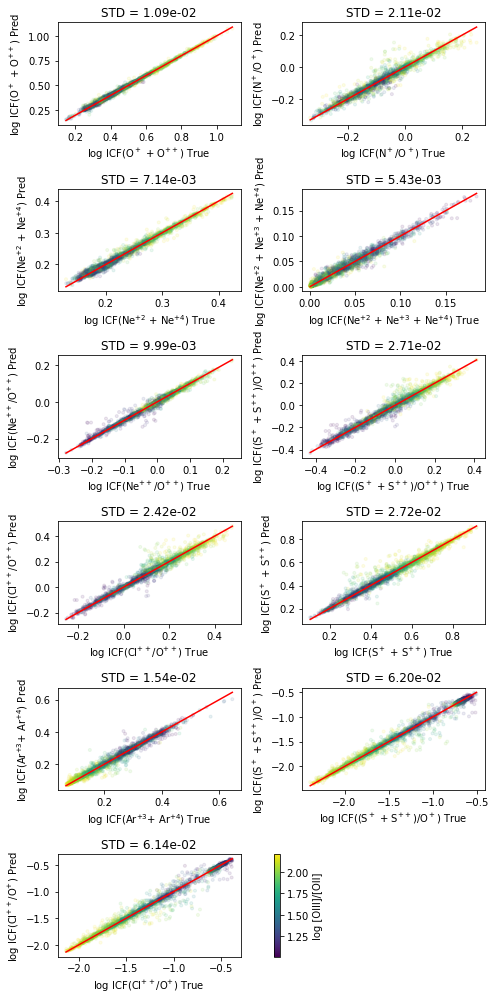

In [8]:
retrain = True
if retrain:
    abund.train(tol=0.6, retrain=True, hidden_layer_sizes=(50,50,50), learning_rate=.1, 
                n_estimators=500, max_depth=10, save=True, oob_score=True, n_jobs=12)
    abund.plot_RM()
else:
    abund.train(retrain=False)

In [9]:
abund.use_ANN = True
abund.diagnostics(plot_diags = False)

Doing ANN for the getCrossTemDen (only once)
4542A ['1640A', '1215A', '1084A', '4686A', '3203A', '6560A', '5411A', '4859A', '4541A', '6407A', '4198A']
4634A ['4641+', '4100+']
4640A ['4638.86A', '4641.81A', '4649.13A', '4650.84A', '4661.63A', '4673.73A', '4676.23A', '4696.35A', '4317.14A', '4336.86A', '4345.56A', '4349.43A', '4366.89A', '4414.90A', '4416.97A', '4069.62A', '4069.88A', '4072.15A', '4075.86A', '4078.84A', '4085.11A', '4092.93A', '4590.97A', '4596.18A', '4121.46A', '4132.80A', '4153.30A', '4104.99A', '4110.79A', '4119.22A', '4120.28A', '4185.44A', '4189.79A', '4087.15A', '4089.29A', '4095.64A', '4097.26A', '4275.55A', '4282.96A']
6235A ['1640A', '1215A', '1084A', '4686A', '3203A', '6560A', '5411A', '4859A', '4541A', '6407A', '4198A']
6527A ['1640A', '1215A', '1084A', '4686A', '3203A', '6560A', '5411A', '4859A', '4541A', '6407A', '4198A']
Instantiation. V 0.17
Training set size = 900, Test set size = 0
Train data scaled. Log10 applied. 
Test data scaled. 
Training set size 

/Users/christophemorisset/Google Drive/Pro/PyNeb_devel/pyneb/core/pynebcore.py:4587: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data_tab = np.genfromtxt(obsFile, dtype=None, delimiter=delimiter, names=True)


RM trained, with 5179 iterations. Score = 0.999
MLPRegressor(activation='tanh', hidden_layer_sizes=(10, 30, 10), max_iter=20000,
             random_state=43, solver='lbfgs')
Training time 10.6 s.
Test data scaled. Log10 applied. 
Training set size = 900, Test set size = 1
Predicting from 2 inputs to 2 outputs using 1 data in 0.00 secs.
RM save to ANN_tn2_ds2.ai4neb_sk
Instantiation. V 0.17
Training set size = 900, Test set size = 0
Train data scaled. Log10 applied. 
Test data scaled. 
Training set size = 900, Test set size = 0
Training set size = 900, Test set size = 0
Regression Model SK_ANN
Training 2 inputs for 2 outputs with 900 data
RM trained, with 2345 iterations. Score = 1.000
MLPRegressor(activation='tanh', hidden_layer_sizes=(10, 30, 10), max_iter=20000,
             random_state=43, solver='lbfgs')
Training time 4.7 s.
Test data scaled. Log10 applied. 
Training set size = 900, Test set size = 1
Predicting from 2 inputs to 2 outputs using 1 data in 0.00 secs.
RM save to ANN_

<ipython-input-6-60a463ae516f>:180: RuntimeWarning: Mean of empty slice
  self.temp_high = np.nanmean( np.array( (self.diags_dict['tem']['o3_cl3'],
<ipython-input-6-60a463ae516f>:182: RuntimeWarning: Mean of empty slice
  self.dens_high = np.nanmean( np.array( (self.diags_dict['den']['o3_cl3'],


   None: Plot Diagnostics done in 120.80295968055725


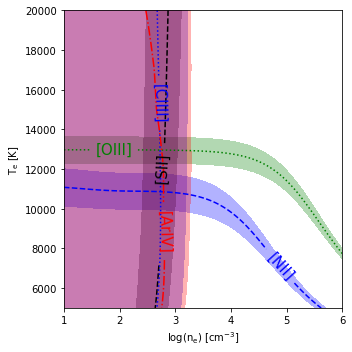

In [10]:
f, ax = plt.subplots(figsize=(5,5))
abund.diags.addClabel(label='[OIII] 4363/5007+', clabel='[OIII]')
abund.diags.addClabel(label='[SII] 6731/6716', clabel='               [SII]')
emisgrids = pn.getEmisGridDict(atomDict = abund.diags.atomDict, den_max=1e6)
CSs = abund.diags.plot(emisgrids, abund.obs, i_obs = 0, ax = ax, 
                       col_dic={'C':'cyan', 'N':'blue', 'O':'green', 'Ne':'magenta',
                                'Ar':'red', 'Cl':'blue', 'S':'black', 'Fe':'blue'})
f.tight_layout()
f.savefig('./Diags2.pdf')
pn.log_.timer('Plot Diagnostics done', quiet=False)

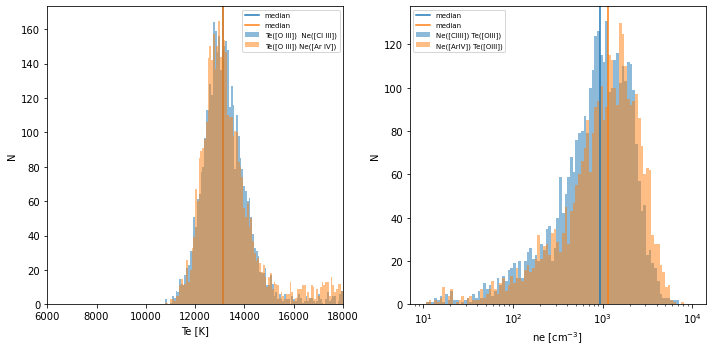

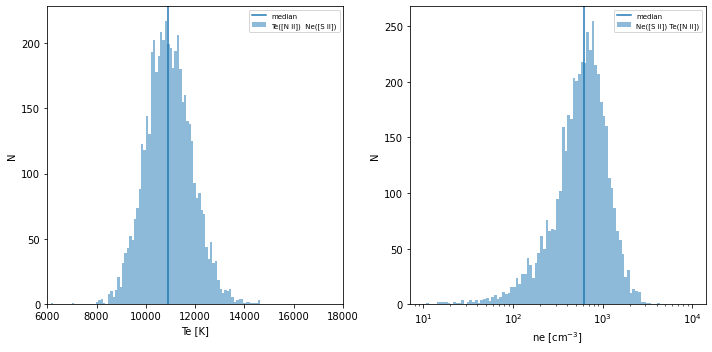

In [11]:
abund.plot_tene_high(legend_size=7, use_log=True)
abund.plot_tene_low(legend_size=7, use_log=True)
abund.table_tene()

In [12]:
abund.get_ion_ab()
abund.get_mean_ion_ab()
abund.get_tot_ab() # This is where X_test is set to the observed MC values

Test data scaled. Log10 applied. 
Training set size = 13015, Test set size = 5001
Predicting from 6 inputs to 11 outputs using 5001 data in 0.12 secs.


<ipython-input-6-60a463ae516f>:219: RuntimeWarning: Mean of empty slice
  x = np.nanmean(self.ionic_mean[ion], axis = 0)


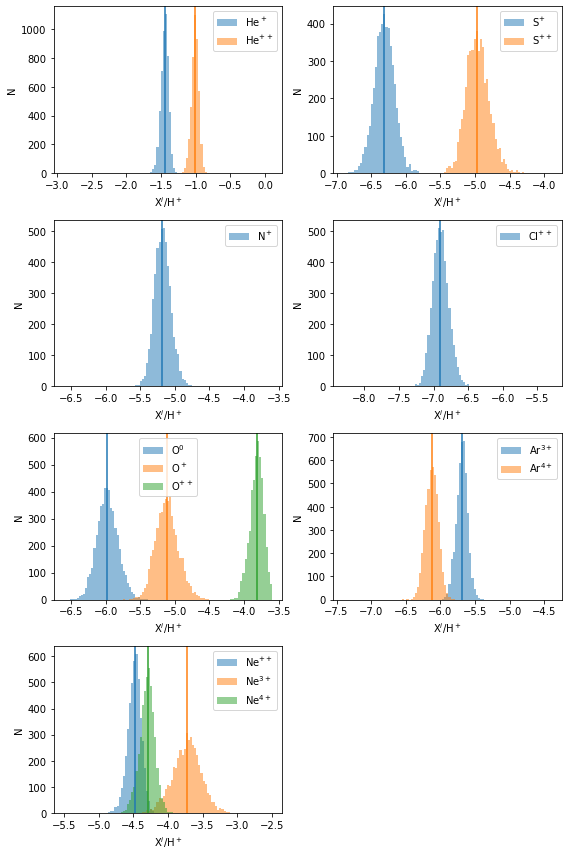

In [13]:
abund.plot_all_ionic() 

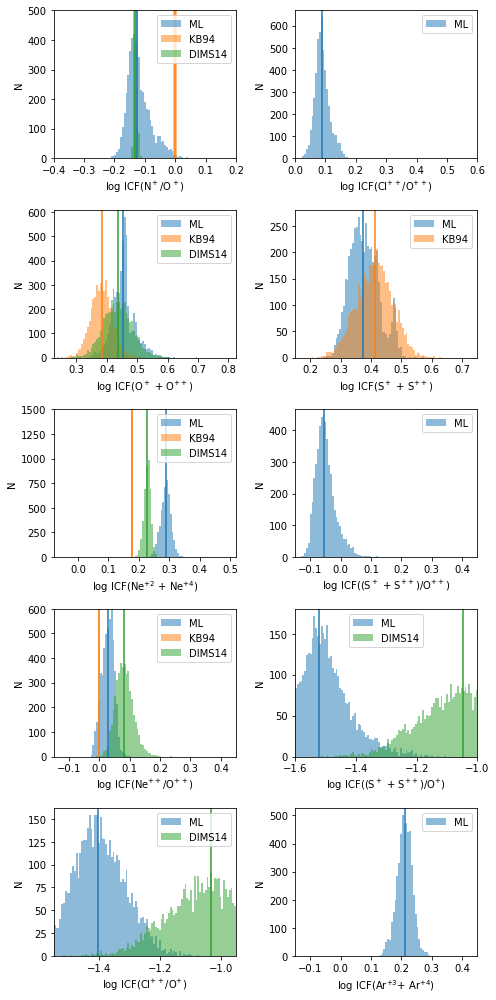

In [14]:
abund.plot_all_icf()

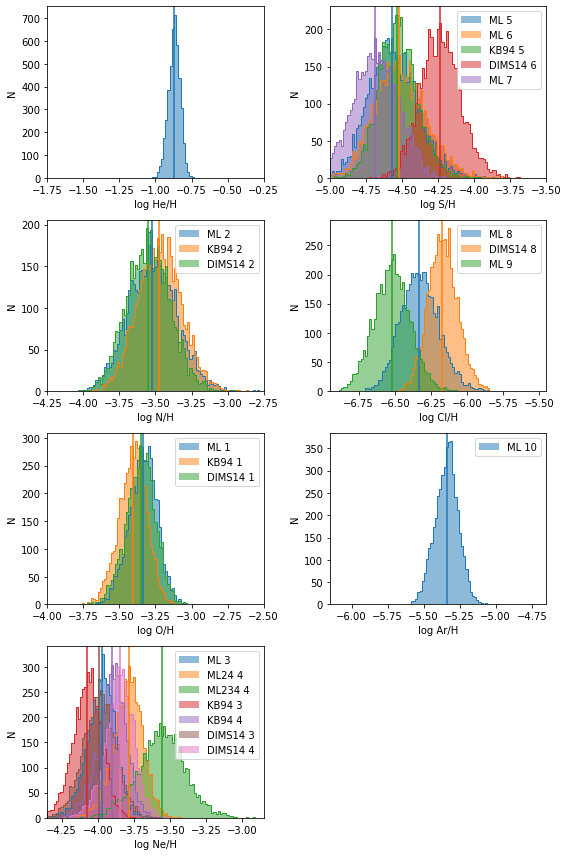

In [15]:
abund.plot_all_elem() 

In [16]:
abund.table_tene()
abund.table_ionic()
abund.table_icf()
abund.table_elem()

In [17]:
data_used = pn.atomicData.usedFiles
for d in data_used:
    print(d, data_used[d])

N2 ['n_ii_atom_FFT04.dat', 'n_ii_coll_T11.dat', 'n_ii_rec_FSL11.func']
O3 ['o_iii_atom_FFT04-SZ00.dat', 'o_iii_coll_SSB14.dat', 'o_iii_rec_P91.func']
S2 ['s_ii_atom_RGJ19.dat', 's_ii_coll_TZ10.dat']
Cl3 ['cl_iii_atom_RGJ19.dat', 'cl_iii_coll_BZ89.dat']
Ar4 ['ar_iv_atom_RGJ19.dat', 'ar_iv_coll_RB97.dat']
Ar5 ['ar_v_atom_LL93-MZ82-KS86.dat', 'ar_v_coll_GMZ95.dat']
H1 [None, 'h_i_rec_SH95.hdf5']
He1 [None, 'he_i_rec_Pal12-Pal13.hdf5']
He2 [None, 'he_ii_rec_SH95.hdf5']
N3 ['n_iii_atom_GMZ98.dat', 'n_iii_coll_BP92.dat', 'n_iii_rec_P91.func']
Ne3 ['ne_iii_atom_GMZ97.dat', 'ne_iii_coll_McLB00.dat']
Ne4 ['ne_iv_atom_GFF84.dat', 'ne_iv_coll_G81.dat']
Ne5 ['ne_v_atom_GMZ97-U-BD93.dat', 'ne_v_coll_DPNP13.dat']
O1 ['o_i_atom_WFD96.dat', 'o_i_coll_BK95.dat', 'o_i_rec_P91.func']
O2 ['o_ii_atom_Z82-WFD96.dat', 'o_ii_coll_Kal09.dat', 'o_ii_rec_SSB17-B-opt.hdf5']
S3 ['s_iii_atom_FFTI06.dat', 's_iii_coll_TG99.dat']
